This code fits a multi-output linear regression model to predict the meshed dendritic field, effectively training one linear model per pixel. While the model achieves low MSE on both training and testing sets, visual reconstruction of the predicted images reveals poor performance. Further investigation are done on the results.


Since both training and testing MSE are low, we might be underfitting. The results we got encouraged us to add more complexity to our model.

In [2]:
# Cell 0 - importing relevant libraries

from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage import sobel

In [3]:
# Cell 1

#Load new 250x250 data
X_train = np.load("X_train.npy")
X_test = np.load("X_test.npy")
Y_train = np.load("Y_train.npy")
Y_test = np.load("Y_test.npy")

print("✅ Loaded data:")
print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")


✅ Loaded data:
X_train shape: (200, 5)
Y_train shape: (200, 250, 250)
X_test shape: (51, 5)
Y_test shape: (51, 250, 250)


In [4]:
# Cell 2

# Flatten the outputs
Y_train_flat = Y_train.reshape(Y_train.shape[0], -1)
Y_test_flat = Y_test.reshape(Y_test.shape[0], -1)

print(f"✅ Y_train_flat shape: {Y_train_flat.shape}")
print(f"✅ Y_test_flat shape: {Y_test_flat.shape}")


✅ Y_train_flat shape: (200, 62500)
✅ Y_test_flat shape: (51, 62500)


In [5]:
# Cell 3

# Train the linear model
linear_model = LinearRegression()
linear_model.fit(X_train, Y_train_flat)

print("✅ Linear Regression model trained!")


✅ Linear Regression model trained!


In [6]:
# Cell 4

# Predictions on training set
Y_train_pred_flat = linear_model.predict(X_train)

# Clipped predictions in [0, 1]
Y_train_pred_flat = np.clip(Y_train_pred_flat, 0, 1)

# Residuals
residuals_train = Y_train_flat - Y_train_pred_flat

# MSE on training set
from sklearn.metrics import mean_squared_error

mse_train = mean_squared_error(Y_train_flat, Y_train_pred_flat)
print(f"✅ Training MSE: {mse_train:.6f}")


✅ Training MSE: 0.059286


In [7]:
# Cell 5

# Predictions on testing set
Y_test_pred_flat = linear_model.predict(X_test)

# Clipped predictions in [0, 1]
Y_test_pred_flat = np.clip(Y_test_pred_flat, 0, 1)

# Residuals on testing
residuals_test = Y_test_flat - Y_test_pred_flat

# MSE on testing set 
mse_test = mean_squared_error(Y_test_flat, Y_test_pred_flat)
print(f"✅ Testing MSE: {mse_test:.6f}")


✅ Testing MSE: 0.056756


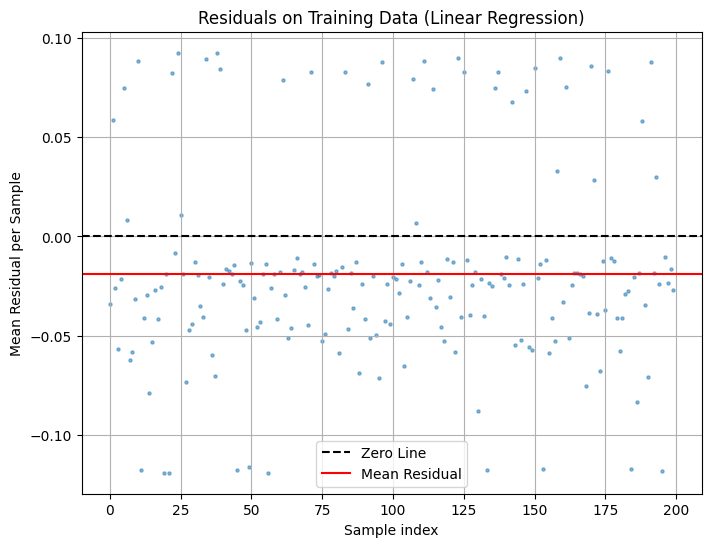

In [8]:
# Cell 6

# Plotting residuals for testing set to see if we have any outlier
# Residuals should be around 0

plt.figure(figsize=(8, 6))
plt.scatter(np.arange(residuals_train.shape[0]), residuals_train.mean(axis=1), alpha=0.5, s=5)
plt.axhline(y=0, color='black', linestyle='--', label='Zero Line')
plt.axhline(y=residuals_train.mean(), color='red', linestyle='-', label='Mean Residual')
plt.xlabel('Sample index')
plt.ylabel('Mean Residual per Sample')
plt.title('Residuals on Training Data (Linear Regression)')
plt.legend()
plt.grid(True)
plt.show()


The deviation from the 0 line is normal. No remarkable outlier.

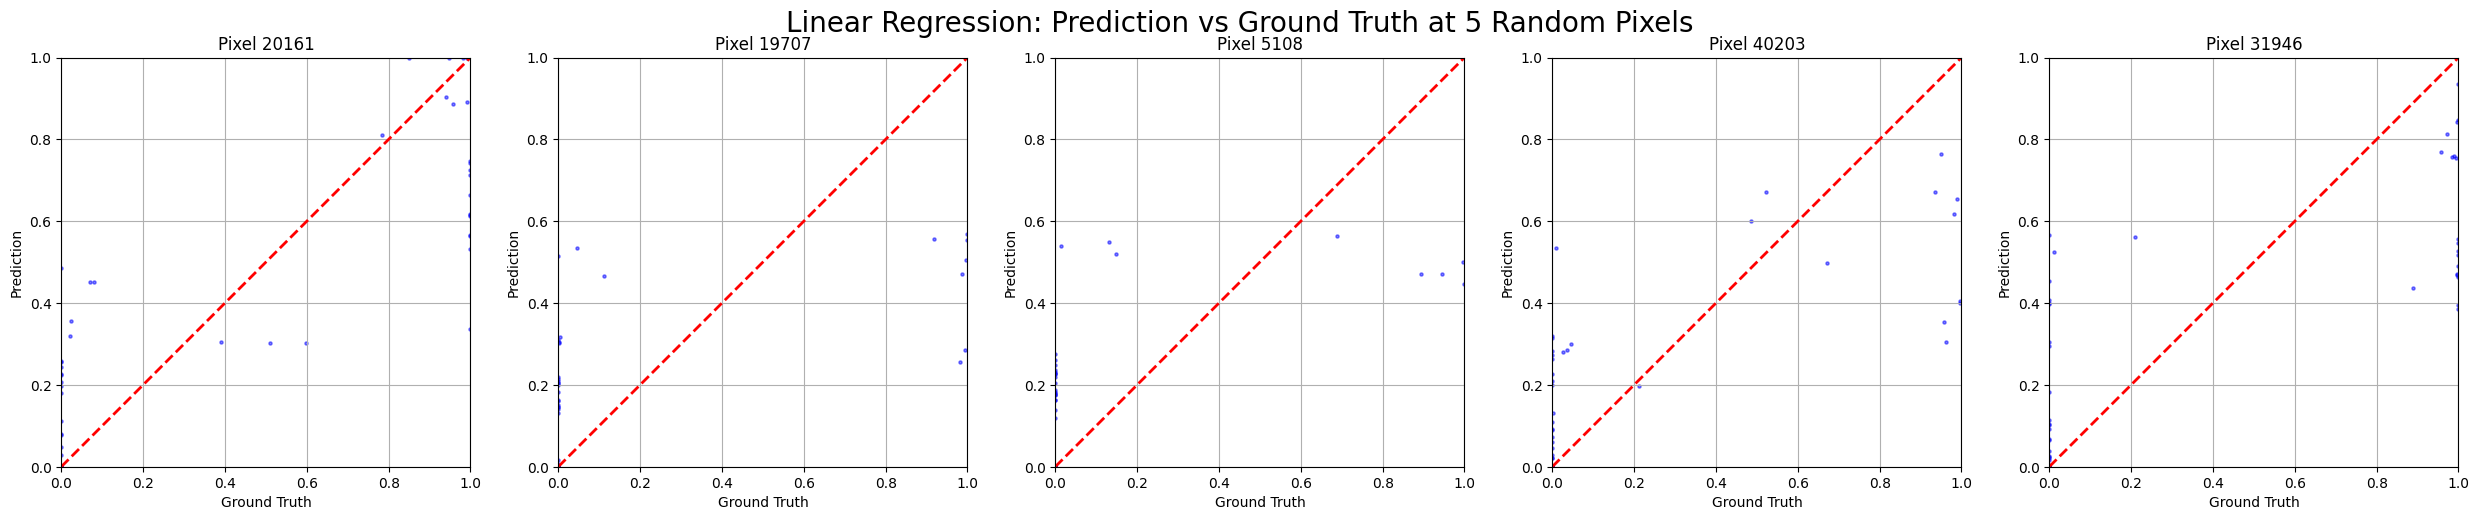

In [9]:
# Cell 7

# To see how linear regression is doing in each cell, plot predictions vs truth. If prediction are good enough, we should 
# see the points near the line y = x.

n_samples, n_pixels = Y_test_flat.shape

# Step 1: Randomly pick 5 pixel locations
np.random.seed(0)
selected_pixels = np.random.choice(n_pixels, size=5, replace=False)

# Step 2: Plot for each selected pixel
fig, axs = plt.subplots(1, 5, figsize=(25, 5))

for i, pixel_idx in enumerate(selected_pixels):
    ax = axs[i]
    
    # True and predicted values at this pixel
    true_pixel = Y_test_flat[:, pixel_idx]
    pred_pixel = Y_test_pred_flat[:, pixel_idx]
    
    # Scatter plot
    ax.scatter(true_pixel, pred_pixel, alpha=0.5, s=5, color='blue', label='Prediction')
    
    # line y = x
    ax.plot([0, 1], [0, 1], 'r--', lw=2, label='Perfect Prediction (y=x)')
    
    ax.set_xlabel('Ground Truth')
    ax.set_ylabel('Prediction')
    ax.set_title(f'Pixel {pixel_idx}')
    ax.grid(True)
    ax.axis('square')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

plt.suptitle('Linear Regression: Prediction vs Ground Truth at 5 Random Pixels', fontsize=20)
plt.tight_layout()
plt.show()



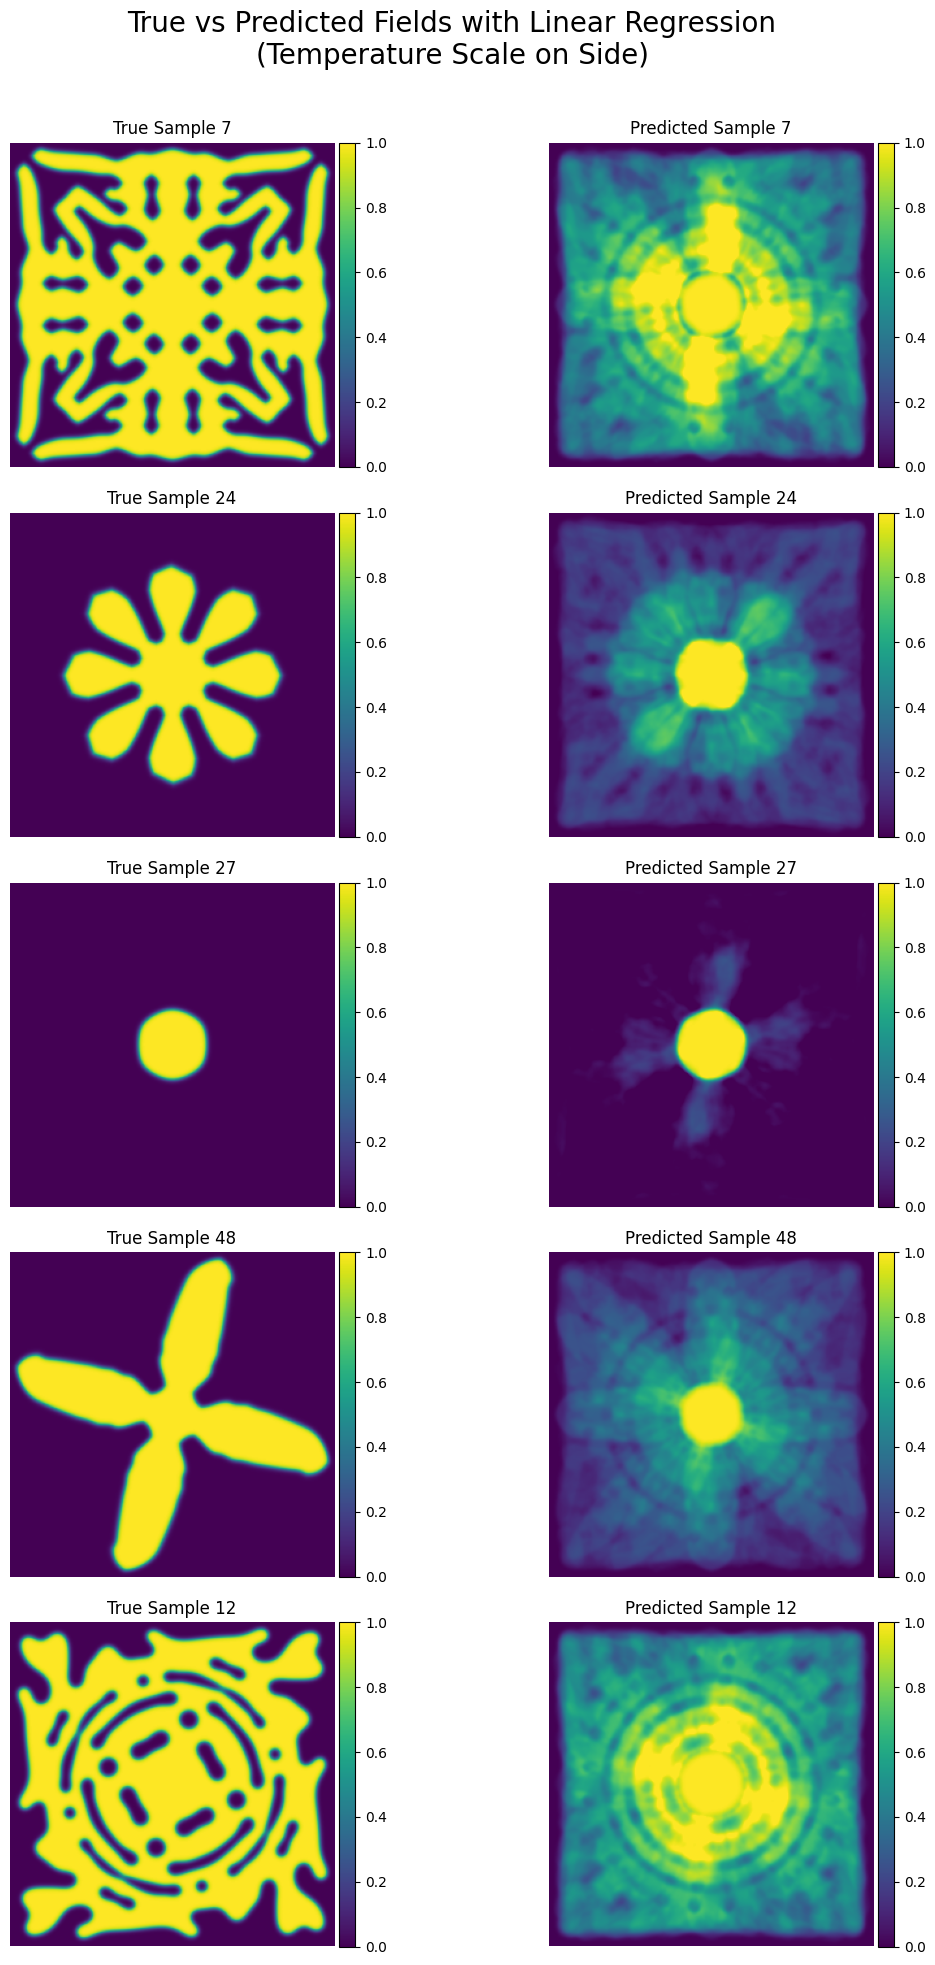

In [17]:
# Cell 8
# Reconstruct 5 predcited final frames and compare them to ground truth

# Step 1: Pick 5 random samples
selected_samples = np.random.choice(Y_test_flat.shape[0], size=5, replace=False)

# Step 2: Set field dimensions
field_size = 250  # because 250x250 fields
assert Y_test_flat.shape[1] == field_size * field_size, "Mismatch in field size!"

# Step 3: Set up plots 
fig, axs = plt.subplots(5, 2, figsize=(12, 20))
vmin = min(Y_test_flat.min(), Y_test_pred_flat.min())
vmax = max(Y_test_flat.max(), Y_test_pred_flat.max())

for i, sample_idx in enumerate(selected_samples):
    # Reconstruct fields
    true_field = Y_test_flat[sample_idx].reshape(field_size, field_size)
    pred_field_raw = Y_test_pred_flat[sample_idx].reshape(field_size, field_size)
    pred_field = np.clip(pred_field_raw, 0, 1)  # Clamp to [0, 1]
    
    # True Plot 
    ax_true = axs[i, 0]
    im_true = ax_true.imshow(true_field, cmap='viridis', vmin=vmin, vmax=vmax)
    ax_true.set_title(f"True Sample {sample_idx}")
    ax_true.axis('off')
    
    divider_true = make_axes_locatable(ax_true)
    cax_true = divider_true.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im_true, cax=cax_true)

    # Predicted Plot
    ax_pred = axs[i, 1]
    im_pred = ax_pred.imshow(pred_field, cmap='viridis', vmin=vmin, vmax=vmax)
    ax_pred.set_title(f"Predicted Sample {sample_idx}")
    ax_pred.axis('off')
    
    divider_pred = make_axes_locatable(ax_pred)
    cax_pred = divider_pred.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im_pred, cax=cax_pred)

plt.suptitle('True vs Predicted Fields with Linear Regression\n(Temperature Scale on Side)', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


We have as predictions an average of the ground truth models.

In [11]:
# Cell 9
# Shape: (n_pixels, n_features)
W = linear_model.coef_  # pixel-wise weights
intercepts = linear_model.intercept_  # shape: (n_pixels,)


### Understanding the SVD of the Linear Model Coefficients

We performed Singular Value Decomposition (SVD) on the coefficient matrix `W` of our trained linear regression model:

W = U S V ^ T

Where:

- `W` is a matrix of shape `(62500, 5)` → one row per pixel (flattened 250×250), one column per input parameter.
- `U`: Shape `(62500, 5)`
  - Each column of `U` is a spatial mode.
  - When reshaped to `(250, 250)`, we can interpret each column as a "basis field" that the model uses to reconstruct the influence of inputs.
- `S`: Shape `(5,)`
  - Singular values — they indicate the relative importance (energy) of each mode. 
  - The first two modes dominate, meaning the model relies mainly on 2 parameter directions to shape its outputs.
- `Vᵀ`: Shape `(5, 5)`
  - Each row represents a linear combination of input parameters that drives a spatial mode in `U`.
  - For example, the first row shows that the dominant mode is influenced mostly by `dT₀` and `c`.


In [12]:
# Cell 10

U, S, Vt = np.linalg.svd(W, full_matrices=False)

C:\Users\Georges\AppData\Local\Temp\ipykernel_11488\864251361.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


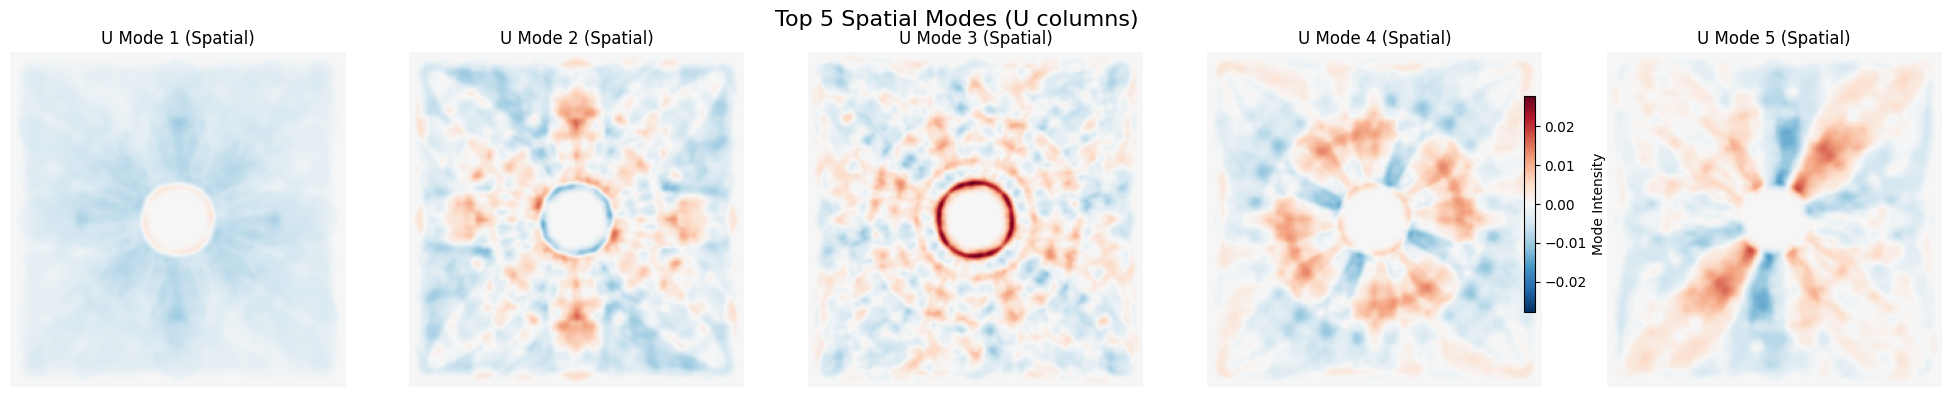

In [13]:
# Cell 10
# plot for U

fig, axs = plt.subplots(1, 5, figsize=(20, 4))

vmax = np.max(np.abs(U[:, :5]))

for i in range(5):
    spatial_mode = U[:, i].reshape(250, 250)
    im = axs[i].imshow(spatial_mode, cmap='RdBu_r', vmin=-vmax, vmax=vmax)
    axs[i].set_title(f'U Mode {i+1} (Spatial)')
    axs[i].axis('off')

# Add one shared colorbar
fig.colorbar(im, ax=axs, orientation='vertical', shrink=0.7, label='Mode Intensity')
plt.suptitle("Top 5 Spatial Modes (U columns)", fontsize=16)
plt.tight_layout()
plt.show()



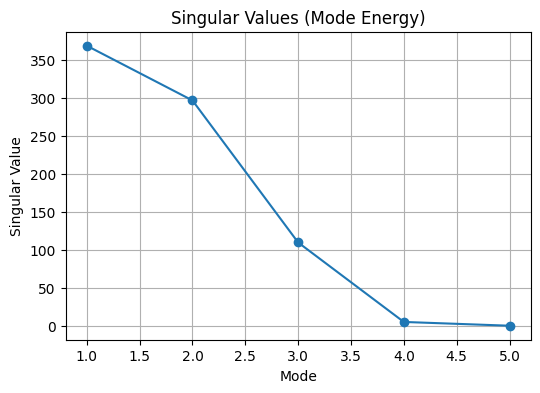

In [14]:
# Cell 12
# Plot for S

plt.figure(figsize=(6,4))
plt.plot(np.arange(1, 6), S, marker='o')
plt.title("Singular Values (Mode Energy)")
plt.xlabel("Mode")
plt.ylabel("Singular Value")
plt.grid(True)
plt.show()


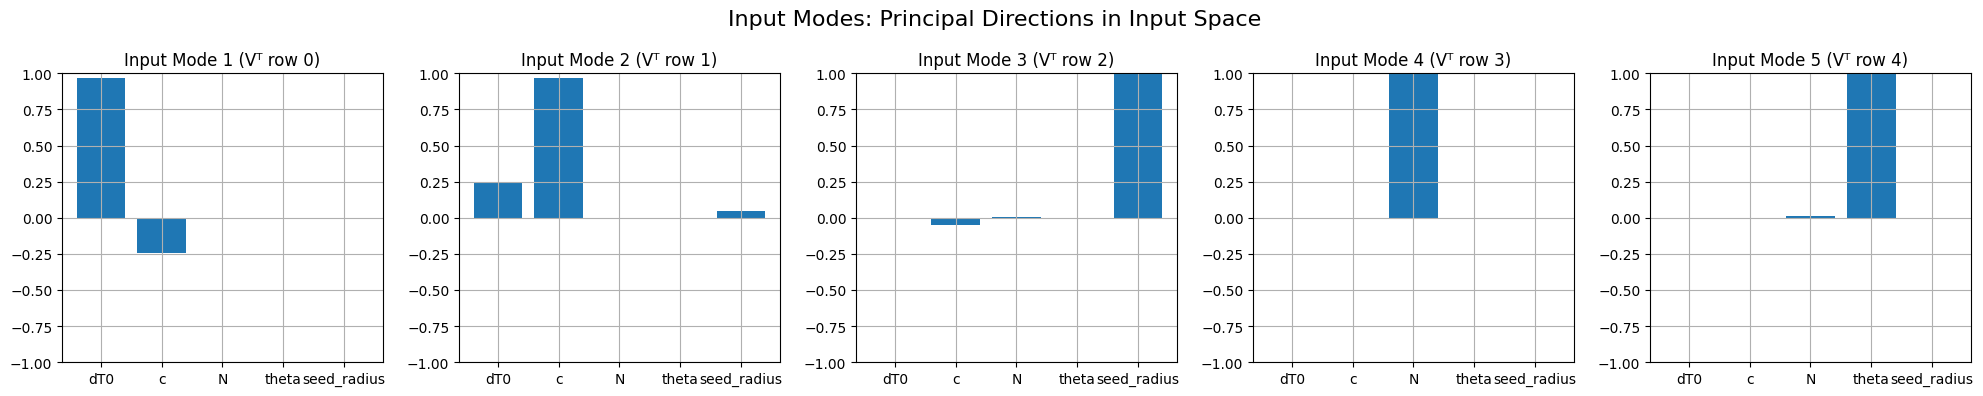

In [15]:
# Cell 13
# Plot for V^t

feature_names = ['dT0', 'c', 'N', 'theta', 'seed_radius']

fig, axs = plt.subplots(1, 5, figsize=(20, 4))

for i in range(5):
    axs[i].bar(feature_names, Vt[i])
    axs[i].set_title(f"Input Mode {i+1} (Vᵀ row {i})")
    axs[i].set_ylim(-1, 1)
    axs[i].grid(True)

plt.suptitle("Input Modes: Principal Directions in Input Space", fontsize=16)
plt.tight_layout()
plt.show()

With 85 % of the energy on the first 2 singular values, all the graphs will be linear combinations of the first 2 basis field.
We also notice that the first 2 input nodes are dominated by T0 (undercooling) and c(anisotropy strength). These parameters are primarily responsible for controlling the extent and rate of dendritic growth rather than the intricate morphological features or branching geometry. This is why we do not see details in the prediction graphs.